In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [3]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
np.set_printoptions(suppress=True)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Session data

In [5]:
selected_009266

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [107]:
session = selected_009266[3]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009266_hippoSIT_2023-04-19_10-33-51'

## Z-scored population PSTH

In [108]:
aeps_tl_idxs = []  # idxs to timeline for AEP events
for event_t in aeps_events[:, 0]:  # AEP event times
    event_idx = (np.abs(tl[:, 0] - event_t)).argmin()
    aeps_tl_idxs.append(event_idx)
aeps_tl_idxs = np.array(aeps_tl_idxs)

In [109]:
sel_units = [unit for unit in unit_names if int(unit[0]) < 3]
#sel_units = [unit for unit in unit_names if int(unit[0]) > 2]
sel_units = unit_names  # all units

bin_size = 0.01  # sec
step = 0.005  # sec 
t_start, t_end = int(tl[0][0]), int(tl[-1][0])
bc = int((t_end - t_start) / bin_size) + 1
exp_coef = round(bin_size/step)
bins = np.linspace(t_start, t_end, bc)
unit_act_matrix = np.zeros([len(sel_units), len(bins) * exp_coef])

for i, unit in enumerate(sel_units):
    spikes = spike_times[unit]
    for offset in range(exp_coef):
        bins = np.linspace(t_start + offset*step, t_end + offset*step, bc)
        vals, _ = np.histogram(spikes, bins=bins)
        idxs = np.arange(offset, (bc - 1) * exp_coef, exp_coef)
        unit_act_matrix[i][idxs] = vals
        
for i, unit_data in enumerate(unit_act_matrix):
    unit_act_matrix[i] = stats.zscore(unit_data)

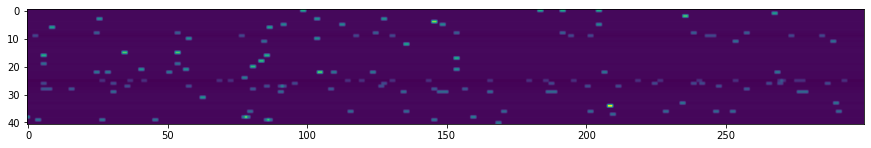

In [110]:
# first seconds
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(unit_act_matrix[:, 0:300])

In [111]:
hw = 0.25   # secs
psth_matrix  = np.zeros([len(aeps_tl_idxs), 2*int(hw/step)])

unit_act_matrix_idxs = np.array([int(x) for x in aeps_tl_idxs*bin_size*(bin_size/step)])
for i, am_idx in enumerate(unit_act_matrix_idxs):
    pop_response = unit_act_matrix[:, am_idx - int(hw/step):am_idx + int(hw/step)].sum(axis=0)
    if len(pop_response) == psth_matrix.shape[1]:
        psth_matrix[i] = pop_response

(-0.25, 0.25)

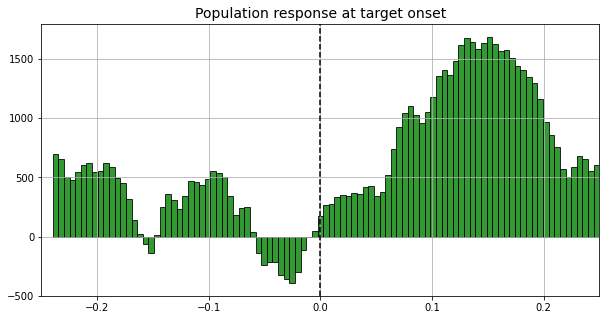

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

weights_all  = psth_matrix.sum(axis=0)

bins = np.linspace(-hw + bin_size, hw + bin_size, psth_matrix.shape[1])
ax.hist(bins, bins=bins, weights=weights_all, edgecolor='black', color='green', alpha=0.8, label='Pop. response')
ax.axvline(0, color='black', ls='--')
ax.set_title("Population response at target onset", fontsize=14)
ax.grid()
ax.set_xlim(-hw, hw)

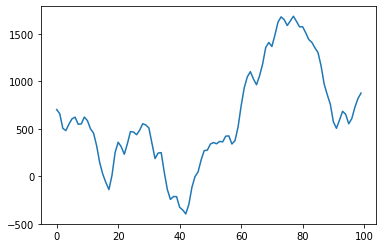

In [113]:
plt.plot(psth_matrix.sum(axis=0))

In [83]:
# separate by behav fit
# moseq_file = os.path.join(source, animal, session, 'moseq.h5')
# with h5py.File(moseq_file, 'r') as f:
#     behav_fit_AL = np.array(f['behav_fit_AL'])
    
# behav_fit_AL[:, 1] = stats.zscore(behav_fit_AL[:, 1])
# idxs_behav_fit = [np.abs(behav_fit_AL[:, 0] - r[0]).argmin() for r in tgt_matrix]
# idxs_high = np.where(behav_fit_AL[idxs_behav_fit][:, 1] > 0)[0]
# idxs_low  = np.where(behav_fit_AL[idxs_behav_fit][:, 1] < 0)[0]


# separate y success / miss
idxs_high = np.where(tgt_matrix[:, 4] == 1)[0]
idxs_low  = np.where(tgt_matrix[:, 4] == 0)[0]


# separate by AEPs metrics (first TGT pulse)
#area, metric = 'A1', 'P1'
#AEP_metrics_norm[area][metric]


weights_all  = psth_matrix.sum(axis=0)
weights_high = psth_matrix[idxs_high].sum(axis=0) / len(idxs_high)
weights_low  = psth_matrix[idxs_low].sum(axis=0) / len(idxs_low)

(-7.0, 7.0)

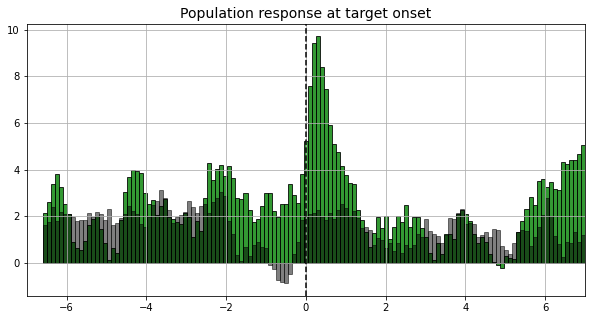

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

bins = np.linspace(-7 + bin_size, 7 + bin_size, psth_matrix.shape[1])
ax.hist(bins, bins=bins, weights=weights_high, edgecolor='black', color='green', alpha=0.8, label='High')
ax.hist(bins, bins=bins, weights=weights_low, edgecolor='black', color='black', alpha=0.5, label='Low')
ax.axvline(0, color='black', ls='--')
ax.set_title("Population response at target onset", fontsize=14)
ax.grid()
ax.set_xlim(-hw, hw)